In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

## Cartera Individual

In [3]:
# Reading Data
data_w = pd.read_excel('../raw_data/weekly_data_clean_with_covid_ind.xlsx', engine='openpyxl')
data_d = pd.read_excel('../raw_data/daily_data_clean_with_covid_ind.xlsx', engine='openpyxl')


In [4]:
# Dropping extra index column
data_w = data_w.drop(columns= 'Unnamed: 0')
data_d = data_d.drop(columns= 'Unnamed: 0')


In [5]:
#Check Nulls
data_w.isnull().sum(), data_d.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [6]:
# Check types and lenght
data_w.dtypes, len(data_w), data_d.dtypes, len(data_d)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 919)

In [7]:
# Setting index as date
data_w = data_w.set_index('date_issue')
data_d = data_d.set_index('date_issue')


In [8]:
data_d

,amount,covid_claims
date_issue,,
2018-09-01,168,0
2018-09-02,332,0
2018-09-03,7453,0
2018-09-04,5025,0
2018-09-05,16023,0
...,...,...
2021-03-04,175724,27
2021-03-05,112495,22
2021-03-06,264350,21


<AxesSubplot:xlabel='date_issue'>

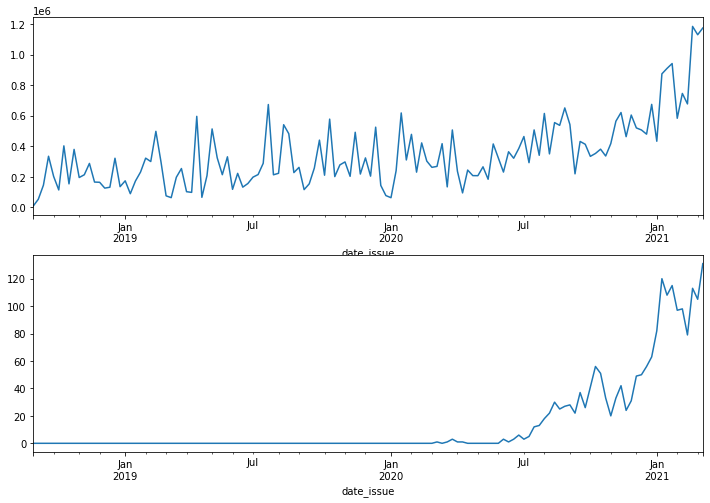

In [9]:
#Plotting weekly
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w['amount'].plot(ax=ax1)
data_w['covid_claims'].plot(ax=ax2)


<AxesSubplot:xlabel='date_issue'>

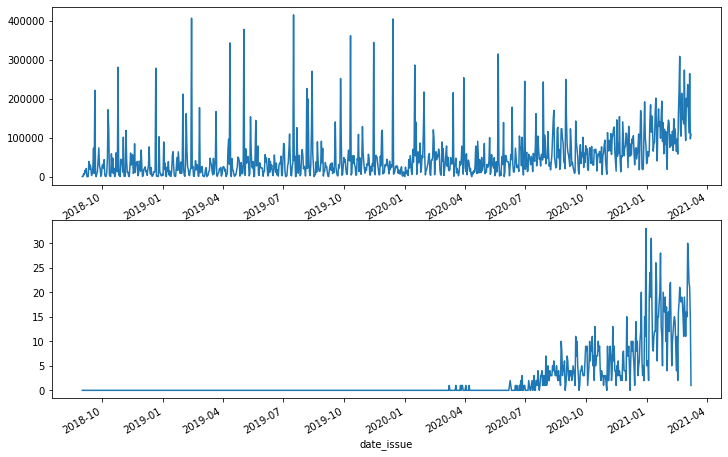

In [10]:
#Plotting daily
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_d['amount'].plot(ax=ax1)
data_d['covid_claims'].plot(ax=ax2)

### Trying with weekly data

In [11]:
# Checking for stationarity
pvalue_a = adfuller(data_w['amount'])[1]

pvalue_c = adfuller(data_w['covid_claims'])[1]

def stationary(pvalue):
    if pvalue < 0.05:
        print('TS is stationary')
    else:
        print('TS is not stationary')
stationary(pvalue_a), pvalue_a, stationary(pvalue_c), pvalue_c

TS is not stationary
TS is not stationary


(None, 0.987088618524165, None, 1.0)

In [12]:
# Splitting Weekly data 

split = 0.8
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]

train.head(1), train.tail(1), test.head(1), test.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-03    7953             0,
             amount  covid_claims
 date_issue                      
 2020-09-07  542183            28,
             amount  covid_claims
 date_issue                      
 2020-09-14  219246            22,
              amount  covid_claims
 date_issue                       
 2021-03-08  1174264           131)

In [13]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [14]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-09-14  219246,
             covid_claims
 date_issue              
 2020-09-14            22,
              amount
 date_issue         
 2021-03-08  1174264,
             covid_claims
 date_issue              
 2021-03-08           131)

### Autoarima raw_data without exogenous variable

In [15]:
autoarima_raw = pm.auto_arima(y = endog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1459.740, Time=1.06 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1489.770, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1438.842, Time=0.87 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1451.666, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1431.872, Time=1.87 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1429.872, Time=0.93 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1431.872, Time=3.85 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.25 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1430.888, Time=2.31 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1430.971, Time=2.29 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1430.312, Time=6.75 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1433.230, Time=1.48 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [16]:
# Split = 0.8
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1429

autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -711.936
Date:                             Fri, 12 Mar 2021   AIC                           1429.872
Time:                                     13:59:38   BIC                           1435.783
Sample:                                          0   HQIC                          1432.145
                                             - 106                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7968      0.247     -3.219      0.001      -1.282      -0.312
ar.S.L52      -0.9315      0.241     -3.869      0.000      -1.403      -0.460
sigma2        4.8e+10   9.48e-13   5.06e+22      0.000     4.8e+10     4.8e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.18   Prob(JB):                         0.43
Heteroskedasticity (H):               0.58   Skew:                             0.41
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+37. Standard errors may be unstable.
"""

In [17]:
# Build model
best_sarima = SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [18]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True)


In [19]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [20]:
predicted_amount = prediction.prediction_results.forecasts[0]

In [68]:
endog_train.tail(1), endog_test.head(1)

(            amount
 date_issue        
 2020-09-07  542183,
             amount  predicted_amount
 date_issue                          
 2020-09-14  219246     679924.576026)

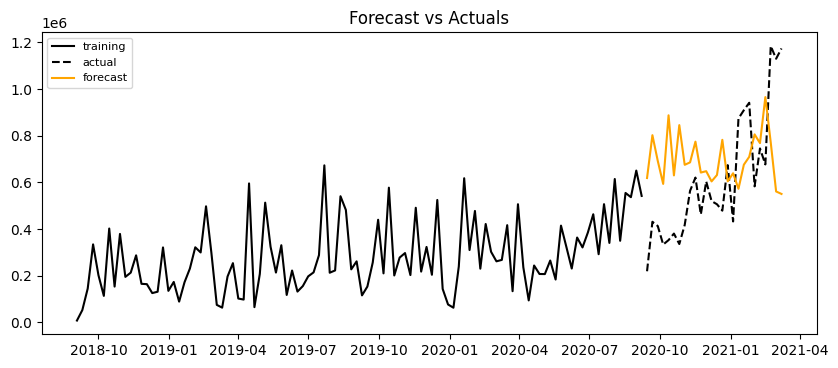

In [21]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [22]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

271472.98573241296

In [23]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.5409877506218398

### Autoarima raw_data with exogenous variable

In [24]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train, X= exog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1461.932, Time=1.36 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1633.678, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1444.275, Time=1.03 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1457.352, Time=0.18 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1437.799, Time=2.48 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1435.800, Time=1.26 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1437.799, Time=4.52 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.56 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1435.869, Time=3.30 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1437.310, Time=2.51 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1436.876, Time=5.29 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1439.048, Time=2.35 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [25]:
autoarima_raw.order


(0, 1, 1)

In [26]:
# Split = 0.8
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1443

autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -713.900
Date:                             Fri, 12 Mar 2021   AIC                           1435.800
Time:                                     14:00:12   BIC                           1443.681
Sample:                                 09-03-2018   HQIC                          1438.830
                                      - 09-07-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims -8473.5948    1.1e+04     -0.767      0.443   -3.01e+04    1.32e+04
ma.L1           -0.6643      0.303     -2.193      0.028      -1.258      -0.071
ar.S.L52        -0.9329      0.255     -3.656      0.000      -1.433      -0.433
sigma2        4.879e+10      0.001    3.4e+13      0.000    4.88e+10    4.88e+10
===================================================================================
Ljung-Box (L1) (Q):                   2.34   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.13   Prob(JB):                         0.36
Heteroskedasticity (H):               0.76   Skew:                             0.44
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.88e+29. Standard errors may be unstable.
"""

In [27]:
# Build model
best_sarima = SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [28]:
prediction = best_sarima.get_prediction(start = '2020-09-14', end = '2021-03-08', dynamic = True, full_results = True, exog = exog_test)

In [29]:
prediction.row_labels

DatetimeIndex(['2020-09-14', '2020-09-21', '2020-09-28', '2020-10-05',
               '2020-10-12', '2020-10-19', '2020-10-26', '2020-11-02',
               '2020-11-09', '2020-11-16', '2020-11-23', '2020-11-30',
               '2020-12-07', '2020-12-14', '2020-12-21', '2020-12-28',
               '2021-01-04', '2021-01-11', '2021-01-18', '2021-01-25',
               '2021-02-01', '2021-02-08', '2021-02-15', '2021-02-22',
               '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [30]:
predicted_amount = prediction.prediction_results.forecasts[0]

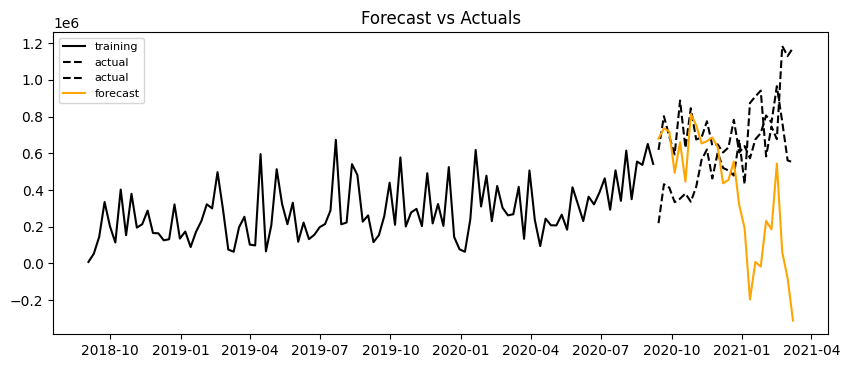

In [31]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [32]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

438880.0535670827

In [33]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.678405619873479

## Trying with daily data

In [34]:
# Splitting Daily data 

split = 0.8
split_index = round(len(data_d)*split)

train_d = data_d.iloc[:split_index]
test_d = data_d.iloc[split_index:]

train_d.head(1), train_d.tail(1), test_d.head(1), test_d.tail(1)

(            amount  covid_claims
 date_issue                      
 2018-09-01     168             0,
             amount  covid_claims
 date_issue                      
 2020-09-05   43955             2,
             amount  covid_claims
 date_issue                      
 2020-09-06   26030             4,
             amount  covid_claims
 date_issue                      
 2021-03-08  108860             1)

In [35]:
# Separating variables
endog_train_d = train_d.drop(columns = 'covid_claims')
exog_train_d = train_d.drop(columns = 'amount')
endog_test_d = test_d.drop(columns = 'covid_claims')
exog_test_d = test_d.drop(columns = 'amount')

In [36]:
endog_test_d.head(1), exog_test_d.head(1), endog_test_d.tail(1), exog_test_d.tail(1)


(            amount
 date_issue        
 2020-09-06   26030,
             covid_claims
 date_issue              
 2020-09-06             4,
             amount
 date_issue        
 2021-03-08  108860,
             covid_claims
 date_issue              
 2021-03-08             1)

### Autoarima raw_data without exogenous variable

In [37]:
autoarima_raw = pm.auto_arima(y = endog_train_d, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=18907.502, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=18492.288, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=18682.170, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=18419.086, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=18557.234, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=18323.466, Time=0.31 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=18392.083, Time=0.18 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.81 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=0.89 sec


In [38]:
# Split = 0.8
# Best model:  ARIMA(2,1,0)(2,1,0)[7]
# AIC = 18323


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  735
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -9156.733
Date:                           Fri, 12 Mar 2021   AIC                          18323.466
Time:                                   14:00:20   BIC                          18346.411
Sample:                                        0   HQIC                         18332.320
                                           - 735                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6742      0.042    -15.921      0.000      -0.757      -0.591
ar.L2         -0.3526      0.045     -7.852      0.000      -0.441      -0.265
ar.S.L7       -0.7091      0.040    -17.702      0.000      -0.788      -0.631
ar.S.L14      -0.3651      0.037     -9.792      0.000      -0.438      -0.292
sigma2      7.354e+09   7.68e-13   9.58e+21      0.000    7.35e+09    7.35e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.76   Jarque-Bera (JB):              1797.50
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.08e+37. Standard errors may be unstable.
"""

In [39]:
# Build model
best_sarima = SARIMAX(endog= endog_train_d, order=(2, 1, 0),seasonal_order=(2, 1, 0, 7))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [40]:
exog_train_d

,covid_claims
date_issue,
2018-09-01,0
2018-09-02,0
2018-09-03,0
2018-09-04,0
2018-09-05,0
...,...
2020-09-01,3
2020-09-02,7
2020-09-03,6


In [41]:
exog_test_d

,covid_claims
date_issue,
2020-09-06,4
2020-09-07,3
2020-09-08,4
2020-09-09,2
2020-09-10,3
...,...
2021-03-04,27
2021-03-05,22
2021-03-06,21


In [47]:
prediction = best_sarima.get_prediction(start = 735, end = 918, dynamic = True, full_results = True)


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [48]:
prediction.row_labels

RangeIndex(start=735, stop=919, step=1)

In [49]:
predicted_amount = prediction.prediction_results.forecasts[0]

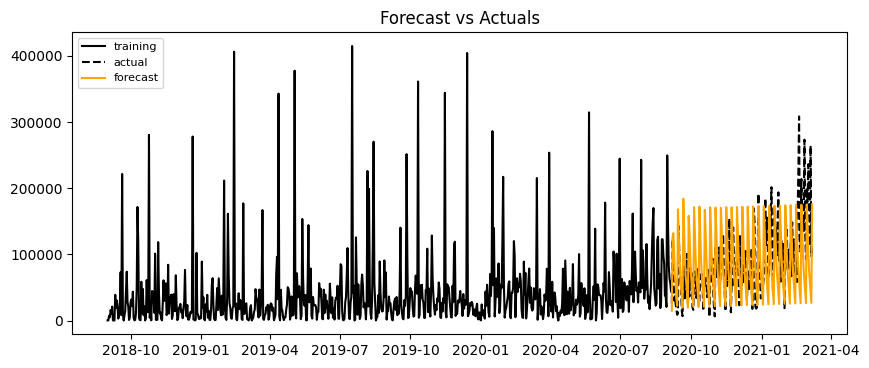

In [50]:
plot_forecast(predicted_amount, endog_train_d, endog_test_d)

In [51]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test_d)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

48075.77104219931

In [52]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.7639674637806265

### Autoarima raw_data with exogenous variable

In [53]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train_d, X= exog_train_d, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=22972.514, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=18496.503, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=18685.612, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=18422.581, Time=0.34 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=18557.729, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=18326.472, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=18395.910, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=0.80 sec


In [55]:
# Split = 0.8
# Best model:  ARIMA(2,10)(2,1,0)[7]
# AIC = 18326


autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  735
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood               -9157.236
Date:                           Fri, 12 Mar 2021   AIC                          18326.472
Time:                                   14:35:00   BIC                          18354.006
Sample:                                        0   HQIC                         18337.097
                                           - 735                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  4001.7659   4541.041      0.881      0.378   -4898.510    1.29e+04
ar.L1           -0.6704      0.042    -15.881      0.000      -0.753      -0.588
ar.L2           -0.3535      0.045     -7.901      0.000      -0.441      -0.266
ar.S.L7         -0.7104      0.040    -17.619      0.000      -0.789      -0.631
ar.S.L14        -0.3678      0.037     -9.868      0.000      -0.441      -0.295
sigma2        7.364e+09      0.006   1.19e+12      0.000    7.36e+09    7.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.77   Jarque-Bera (JB):              1806.09
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+31. Standard errors may be unstable.
"""

In [56]:
best_sarima_d = SARIMAX(endog= endog_train_d, exog= exog_train_d, order=(2, 1, 0),seasonal_order=(2, 1, 0, 7))
best_sarima_d = best_sarima_d.fit()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [57]:
best_sarima_d

In [58]:
exog_test_d

,covid_claims
date_issue,
2020-09-06,4
2020-09-07,3
2020-09-08,4
2020-09-09,2
2020-09-10,3
...,...
2021-03-04,27
2021-03-05,22
2021-03-06,21


In [59]:
endog_train_d

,amount
date_issue,
2018-09-01,168
2018-09-02,332
2018-09-03,7453
2018-09-04,5025
2018-09-05,16023
...,...
2020-09-01,146844
2020-09-02,82846
2020-09-03,63449


In [60]:
prediction = best_sarima_d.get_prediction(start = 735, end = 918, dynamic = True, full_results = True, exog = exog_test_d)

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [61]:
predicted_amount = prediction.prediction_results.forecasts[0]

In [62]:
prediction.row_labels

RangeIndex(start=735, stop=919, step=1)

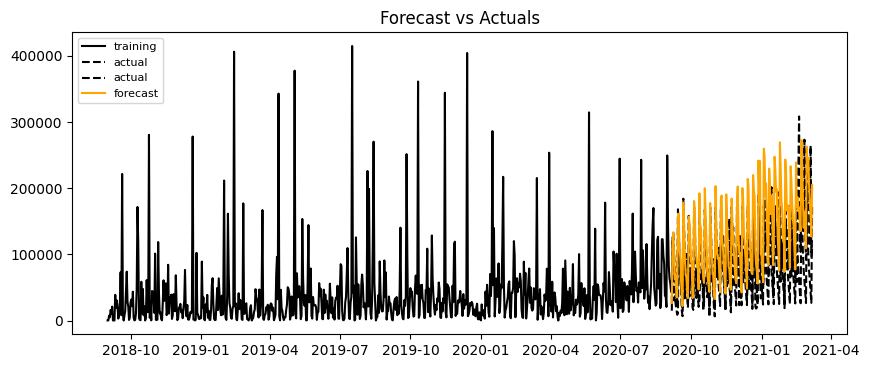

In [63]:
plot_forecast(predicted_amount, endog_train_d, endog_test_d)

In [64]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test_d)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

54063.693252097786

In [65]:
best_sarima_performance

,amount,predicted_amount,absolute_error
date_issue,,,
2020-09-06,26030,26521.220197,491.220197
2020-09-07,122740,119165.060796,3574.939204
2020-09-08,91113,133391.553742,42278.553742
2020-09-09,30586,98352.502325,67766.502325
2020-09-10,36733,62513.207437,25780.207437
...,...,...,...
2021-03-04,175724,206162.883761,30438.883761
2021-03-05,112495,178558.066258,66063.066258
2021-03-06,264350,157142.074016,107207.925984


In [66]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

1.0178424743518257

## Best model (To be Refined): Weekly Data without exogenous variable

Split = 0.8
Best model:  ARIMA(0,1,1)(1,1,0)[52]
AIC = 1429

MAE= 271472.98573241296
MAPE= 0.54

### Let's try changing the split

In [163]:
# Splitting Weekly data 

split = 0.7
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]



In [164]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [165]:
endog_test.head(1), exog_test.head(1), endog_test.tail(1), exog_test.tail(1)


(            amount
 date_issue        
 2020-06-08  230834,
             covid_claims
 date_issue              
 2020-06-08             3,
              amount
 date_issue         
 2021-03-08  1174264,
             covid_claims
 date_issue              
 2021-03-08           131)

In [154]:
autoarima_raw = pm.auto_arima(y = endog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1078.059, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1106.095, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1062.227, Time=0.84 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1069.415, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1057.202, Time=1.60 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1055.202, Time=0.90 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1057.202, Time=3.44 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1057.013, Time=1.50 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1056.584, Time=2.59 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1056.775, Time=2.10 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1058.428, Time=1.32 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [155]:
autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -524.601
Date:                             Fri, 12 Mar 2021   AIC                           1055.202
Time:                                     16:13:57   BIC                           1060.192
Sample:                                          0   HQIC                          1056.992
                                              - 92                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9402      0.284     -3.310      0.001      -1.497      -0.383
ar.S.L52      -0.9352      0.226     -4.145      0.000      -1.377      -0.493
sigma2      4.959e+10   1.91e-12   2.59e+22      0.000    4.96e+10    4.96e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 2.66
Prob(Q):                              0.37   Prob(JB):                         0.26
Heteroskedasticity (H):               0.88   Skew:                             0.63
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.51e+38. Standard errors may be unstable.
"""

In [156]:
# Build model
best_sarima = SARIMAX(endog= endog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [157]:
prediction = best_sarima.get_prediction(start = '2020-06-08', end = '2021-03-08', dynamic = True, full_results = True)


In [158]:
prediction.row_labels

DatetimeIndex(['2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29',
               '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27',
               '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
               '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
               '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [159]:
predicted_amount = prediction.prediction_results.forecasts[0]

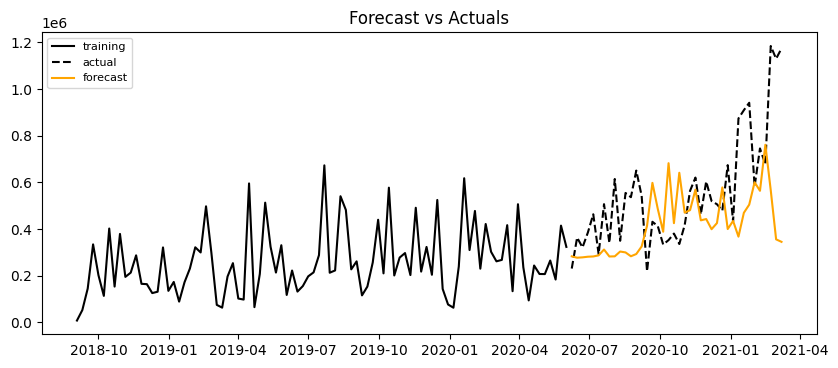

In [160]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [161]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

204818.27751986665

In [162]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.337141776654945

### Split = 0.7

Best model: ARIMA(0,1,1)(1,1,0)[52] AIC = 1055.20

#### MAE= 204818.27751986665 
#### MAPE= 0.337141776654945

### Split = 0.8
Best model:  ARIMA(0,1,1)(1,1,0)[52]
AIC = 1429

#### MAE= 271472.98573241296
#### MAPE= 0.54

### Split = 0.85

Best model: ARIMA(0,1,1)(1,1,0)[52] AIC = 1055.202

#### MAE= 290092.14718067175 
#### MAPE= 0.36057005398379327

### Split = 0.9

Best model: ARIMA(0,1,1)(1,1,0)[52] AIC = 1781

#### MAE= 307848.08253398375 
#### MAPE= 0.3271142961652406

### Split = 0.93

Best model: ARIMA(2,1,1)(1,1,0)[52] AIC = 1889

#### MAE= 402357.3789582357 
#### MAPE= 0.3985715828546961

### We choose Split 0.7

In [184]:
# Splitting Weekly data 

split = 0.7
split_index = round(len(data_w)*split)

train = data_w.iloc[:split_index]
test = data_w.iloc[split_index:]



In [185]:
# Separating variables
endog_train = train.drop(columns = 'covid_claims')
exog_train = train.drop(columns = 'amount')
endog_test = test.drop(columns = 'covid_claims')
exog_test = test.drop(columns = 'amount')

In [190]:
exog_test.head(1), exog_test.tail(1)

(            covid_claims
 date_issue              
 2020-06-08             3,
             covid_claims
 date_issue              
 2021-03-08           131)

###  Trying Autoarima raw_data with exogenous variable with new split

In [186]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train, X= exog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1079.493, Time=1.28 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1193.065, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.51 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1063.196, Time=0.96 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1070.479, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1058.434, Time=1.67 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1056.434, Time=0.90 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1058.434, Time=3.97 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.48 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1058.251, Time=1.63 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1057.649, Time=3.54 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1057.849, Time=1.91 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1059.650, Time=1.49 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [187]:
# Split = 0.7
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1056

autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -524.217
Date:                             Fri, 12 Mar 2021   AIC                           1056.434
Time:                                     16:27:29   BIC                           1063.088
Sample:                                 09-03-2018   HQIC                          1058.821
                                      - 06-01-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  4.698e+04   1.35e+05      0.347      0.728   -2.18e+05    3.12e+05
ma.L1           -0.9313      0.292     -3.192      0.001      -1.503      -0.359
ar.S.L52        -0.9311      0.246     -3.784      0.000      -1.413      -0.449
sigma2          4.8e+10      0.021   2.25e+12      0.000     4.8e+10     4.8e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.44   Prob(JB):                         0.37
Heteroskedasticity (H):               0.88   Skew:                             0.55
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.37e+29. Standard errors may be unstable.
"""

In [191]:
# Build model
best_sarima = SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [192]:
prediction = best_sarima.get_prediction(start = '2020-06-08', end = '2021-03-08', dynamic = True, full_results = True, exog = exog_test)

In [193]:
prediction.row_labels

DatetimeIndex(['2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29',
               '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27',
               '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
               '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
               '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [194]:
predicted_amount = prediction.prediction_results.forecasts[0]

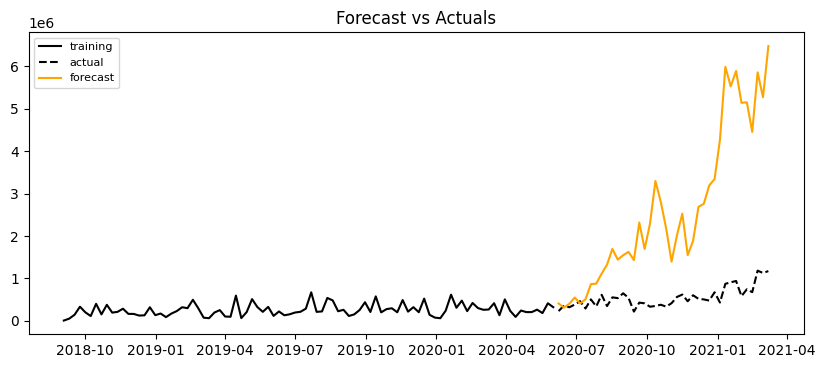

In [195]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [182]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

2066535.1063525588

In [183]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

3.5467818062169743

#### Let's try detrending exogenous variable

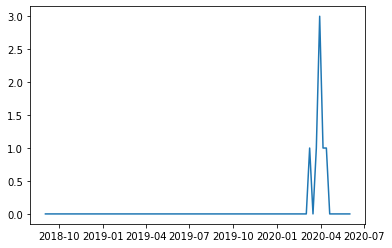

In [210]:
plt.plot(exog_train)

In [197]:
# Applying log 
det_exog_train = np.log(exog_train)
det_exog_test = np.log(exog_test)

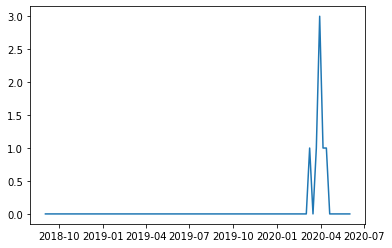

In [199]:
plt.plot(exog_train)

In [201]:
exog_train

,covid_claims
date_issue,
2018-09-03,0
2018-09-10,0
2018-09-17,0
2018-09-24,0
2018-10-01,0
...,...
2020-05-04,0
2020-05-11,0
2020-05-18,0


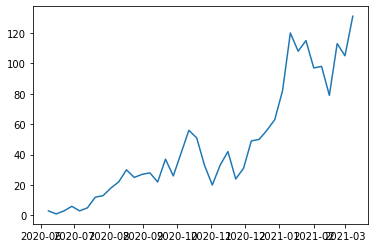

In [200]:
plt.plot(exog_test)

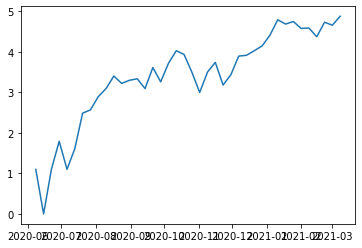

In [211]:
plt.plot(det_exog_test)

In [202]:
# Autoarima raw_data with exogenous variable

autoarima_raw = pm.auto_arima(y = endog_train, X= exog_train, start_p=0, start_q=0,
                             max_p=2, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1079.493, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1193.065, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1063.196, Time=1.45 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1070.479, Time=0.24 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1058.434, Time=2.33 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1056.434, Time=1.07 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1058.434, Time=3.88 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=4.10 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1058.251, Time=1.51 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1057.649, Time=3.43 sec
 ARIMA(1,1,2)(1,1,0)[52]             : AIC=1057.849, Time=1.76 sec
 ARIMA(0,1,1)(1,1,0)[52] intercept   : AIC=1059.650, Time=1.52 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

In [187]:
# Split = 0.7
# Best model:  ARIMA(0,1,1)(1,1,0)[52]
# AIC = 1056

autoarima_raw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -524.217
Date:                             Fri, 12 Mar 2021   AIC                           1056.434
Time:                                     16:27:29   BIC                           1063.088
Sample:                                 09-03-2018   HQIC                          1058.821
                                      - 06-01-2020                                         
Covariance Type:                               opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
covid_claims  4.698e+04   1.35e+05      0.347      0.728   -2.18e+05    3.12e+05
ma.L1           -0.9313      0.292     -3.192      0.001      -1.503      -0.359
ar.S.L52        -0.9311      0.246     -3.784      0.000      -1.413      -0.449
sigma2          4.8e+10      0.021   2.25e+12      0.000     4.8e+10     4.8e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.44   Prob(JB):                         0.37
Heteroskedasticity (H):               0.88   Skew:                             0.55
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.37e+29. Standard errors may be unstable.
"""

In [203]:
# Build model
best_sarima = SARIMAX(endog= endog_train, exog= exog_train, order=(0, 1, 1),seasonal_order=(1, 1, 0, 52))
best_sarima = best_sarima.fit()


/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [204]:
prediction = best_sarima.get_prediction(start = '2020-06-08', end = '2021-03-08', dynamic = True, full_results = True, exog = det_exog_test)

In [205]:
prediction.row_labels

DatetimeIndex(['2020-06-08', '2020-06-15', '2020-06-22', '2020-06-29',
               '2020-07-06', '2020-07-13', '2020-07-20', '2020-07-27',
               '2020-08-03', '2020-08-10', '2020-08-17', '2020-08-24',
               '2020-08-31', '2020-09-07', '2020-09-14', '2020-09-21',
               '2020-09-28', '2020-10-05', '2020-10-12', '2020-10-19',
               '2020-10-26', '2020-11-02', '2020-11-09', '2020-11-16',
               '2020-11-23', '2020-11-30', '2020-12-07', '2020-12-14',
               '2020-12-21', '2020-12-28', '2021-01-04', '2021-01-11',
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08'],
              dtype='datetime64[ns]', freq='W-MON')

In [206]:
predicted_amount = prediction.prediction_results.forecasts[0]

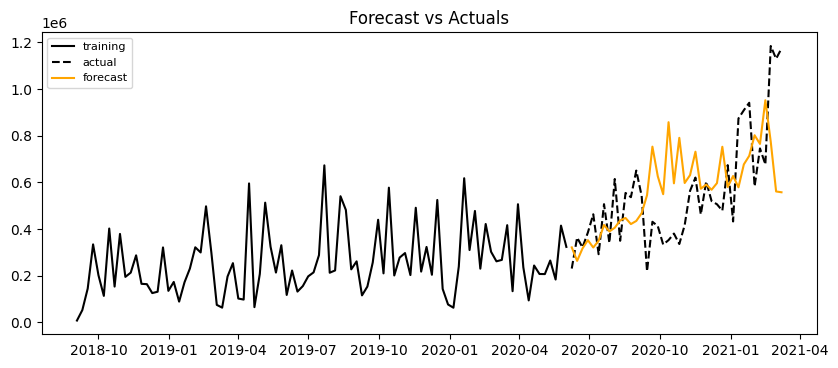

In [207]:
plot_forecast(predicted_amount, endog_train, endog_test)

In [208]:
# computing mae
best_sarima_performance = pd.DataFrame(endog_test)
best_sarima_performance['predicted_amount'] = predicted_amount
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['predicted_amount'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

191914.88398252337

In [209]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['predicted_amount'])

0.38125980357624434

In [213]:
# The above was not valid

### Best Model

### Split = 0.7

Best model: ARIMA(0,1,1)(1,1,0)[52] AIC = 1055.20

#### MAE= 204818.27751986665 
#### MAPE= 0.337141776654945

No exog variable

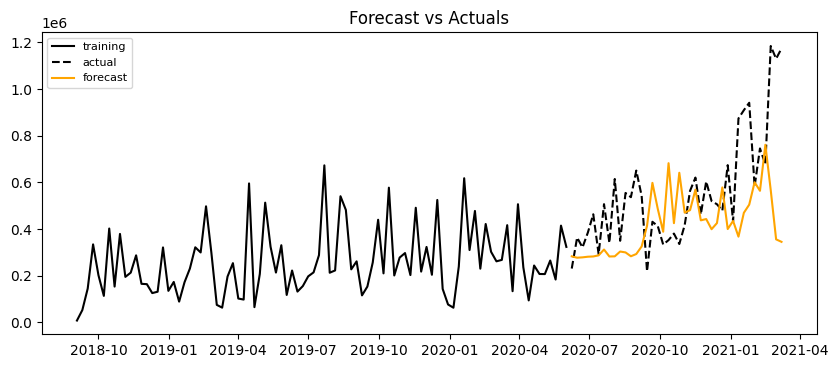


